## Preprocessing

Agenda:
- Preprocess the report sections
- Generate the json file used for llava-med training

In [1]:
import pandas as pd

### EDA

In [2]:
single_image_paths_df = pd.read_csv("./processed_data/single_image_paths.csv")
single_image_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100384 entries, 0 to 100383
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   study_id     100384 non-null  int64 
 1   size         100384 non-null  int64 
 2   subject_id   100384 non-null  int64 
 3   report_path  100384 non-null  object
 4   dicom_id     100384 non-null  object
 5   split        100384 non-null  object
 6   image_path   100384 non-null  object
dtypes: int64(3), object(4)
memory usage: 5.4+ MB


In [3]:
# report_sectioned_df = pd.read_csv("./legacy/mimic_cxr_sectioned.csv")
# report_sectioned_df["study_id"] = report_sectioned_df["study"].apply(lambda x: x[1:])

# # convert the type to int64 which is the same as that in singles_image_df
# report_sectioned_df["study_id"] = report_sectioned_df["study_id"].astype("int64")
# report_sectioned_df.drop("study", axis=1, inplace=True)

# report_sectioned_df.info()

In [4]:
# single_image_report_df = single_image_paths_df.merge(report_sectioned_df, on="study_id", how="inner")
# single_image_report_df

In [5]:
# for f in single_image_report_df["findings"]:
#   print(f)

**Conclusion:** Using the `findings` might not be the best way to train the model. For example, data points such as "Portable upright chest film ___ at 07:43 is submitted." do not help.

In [6]:
# # Use original script to parse the reports
# # sections are chosen in the following order of decreasing priority 
# # ("impression", "findings", "last_paragraph", "comparison")

# report_sections_df = pd.read_csv("./legacy/mimic_cxr_sections.csv", names=["study", "report"])
# # report_sections_df
# for r in report_sections_df["report"]:
#   print(r)

**Conclusion:** Using impression as first priority only returns the "diagnosis" for the image but not the explanation of what the image shows.

## Part 1: Normal preprocessing of reports
We will take the section with the longest length as the section that is the most descriptive of the image

- Remove rows that have no report/ indication
- Remove unnecessary whitespace, \n
- Remove reports that refer to more than 1 image
- Remove corrupted images

In [7]:
import pandas as pd
import numpy as np

In [8]:
report_sections_df = pd.read_csv(
    "./processed_data/modified_mimic_cxr_sections_with_indication.csv"
    #  , names=["study", "report"]
)
report_sections_df
# for r in report_sections_df["report"]:
#   print(r)

,study,report,indication
0,s53189527,"The cardiac, mediastinal and hilar contours ar...",History: ___F with shortness of breath
1,s53911762,Single frontal view of the chest provided.\n \...,___F with cough // acute process?
2,s50414267,"There is no focal consolidation, pleural effus...",___F with new onset ascites // eval for infec...
3,s56699142,"The lungs are clear of focal consolidation, pl...",___ year old woman with cirrhosis.
4,s57375967,PA and lateral views of the chest provided. ...,"___M with hypoxia // ?pna, aspiration."
...,...,...,...
227830,s58708861,ET tube ends 4.7 cm above the carina. NG tube...,"Patient with intubation, evaluation for ETT pl..."
227831,s57132437,"The lungs are clear, and the cardiomediastinal...",___-year-old with chest pain.
227832,s58971208,The ET tube terminates approximately 2.9 cm fr...,"___-year-old female intubated for head bleed, ..."
227833,s58621812,Portable supine AP view of the chest provided ...,Transfer from outside hospital with intubation...


In [9]:
report_sections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227835 entries, 0 to 227834
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   study       227835 non-null  object
 1   report      227805 non-null  object
 2   indication  222710 non-null  object
dtypes: object(3)
memory usage: 5.2+ MB


### 1a. Fix the study_id to merge with the single image paths
- Convert the `study` `string` column into `study_id` `int` column

In [10]:
report_sections_df["study_id"] = report_sections_df["study"].apply(lambda x: x[1:])

# convert the type to int64 which is the same as that in singles_image_df
report_sections_df["study_id"] = report_sections_df["study_id"].astype("int64")
report_sections_df.drop("study", axis=1, inplace=True)
report_sections_df

,report,indication,study_id
0,"The cardiac, mediastinal and hilar contours ar...",History: ___F with shortness of breath,53189527
1,Single frontal view of the chest provided.\n \...,___F with cough // acute process?,53911762
2,"There is no focal consolidation, pleural effus...",___F with new onset ascites // eval for infec...,50414267
3,"The lungs are clear of focal consolidation, pl...",___ year old woman with cirrhosis.,56699142
4,PA and lateral views of the chest provided. ...,"___M with hypoxia // ?pna, aspiration.",57375967
...,...,...,...
227830,ET tube ends 4.7 cm above the carina. NG tube...,"Patient with intubation, evaluation for ETT pl...",58708861
227831,"The lungs are clear, and the cardiomediastinal...",___-year-old with chest pain.,57132437
227832,The ET tube terminates approximately 2.9 cm fr...,"___-year-old female intubated for head bleed, ...",58971208
227833,Portable supine AP view of the chest provided ...,Transfer from outside hospital with intubation...,58621812


In [11]:
report_sections_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227835 entries, 0 to 227834
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   report      227805 non-null  object
 1   indication  222710 non-null  object
 2   study_id    227835 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.2+ MB


#### Join with the single AP image datapoints (to improve the efficiency of the preprocessing)

In [12]:
single_image_report_df = single_image_paths_df.merge(report_sections_df, on="study_id", how="inner")
single_image_report_df

,study_id,size,subject_id,report_path,dicom_id,split,image_path,report,indication
0,50000014,1,11941242,files/p11/p11941242/s50000014.txt,dffc8ab2-ff37704f-2fb29e6d-51e08075-88bca914,train,files/p11/p11941242/s50000014/dffc8ab2-ff37704...,Lung volumes are low. Retrocardiac opacity wi...,___-year-old woman presenting with weakness. ...
1,50000052,1,15752761,files/p15/p15752761/s50000052.txt,a09e5a6c-9635efa7-de26c04a-28104ce9-e5f798d6,train,files/p15/p15752761/s50000052/a09e5a6c-9635efa...,Support lines and tubes are unchanged in posit...,___ year old man with respiratoyr failure and ...
2,50000125,1,19309850,files/p19/p19309850/s50000125.txt,dfa001f0-9c3d0a8c-b61096ea-e3b90c21-6228ddff,train,files/p19/p19309850/s50000125/dfa001f0-9c3d0a8...,There has been interval resolution of the mode...,___ year old man with post-ICD firing pulmonar...
3,50000173,1,19999287,files/p19/p19999287/s50000173.txt,c8bbb9ff-ecb81ef7-a1a6cecf-f535bd20-bd512ba0,train,files/p19/p19999287/s50000173/c8bbb9ff-ecb81ef...,Compared to the prior study the ET tube has be...,___ y.o female with SCC and recent stent place...
4,50000198,1,16548129,files/p16/p16548129/s50000198.txt,b66847d6-6848ea1f-58aa0c60-c38316ff-7e2171db,train,files/p16/p16548129/s50000198/b66847d6-6848ea1...,Heart size is normal. The mediastinal and hil...,History: ___F with shortness of breath
...,...,...,...,...,...,...,...,...,...
100379,59999594,1,11278050,files/p11/p11278050/s59999594.txt,2d21fa2b-c28a3633-6a5f9561-37be4527-7a2b8475,train,files/p11/p11278050/s59999594/2d21fa2b-c28a363...,As compared to the previous radiograph from __...,___ year old man with aortic stenosis s/p TAVR...
100380,59999682,1,15376482,files/p15/p15376482/s59999682.txt,6e2ad8f2-02cc64d6-b52add4b-526b833c-e2e185b7,train,files/p15/p15376482/s59999682/6e2ad8f2-02cc64d...,In comparison with the earlier study of this d...,Central line placement.
100381,59999807,1,19497741,files/p19/p19497741/s59999807.txt,e56dbf08-8b564eb4-831fa870-d590f7c7-423cb05f,train,files/p19/p19497741/s59999807/e56dbf08-8b564eb...,A right hemodialysis catheter ends in the atri...,Myasthenia crisis with prior hematoma. Evalua...
100382,59999824,1,19148695,files/p19/p19148695/s59999824.txt,66bd155f-6b30082b-9a7aa677-b6ff2ac7-d29e2f49,train,files/p19/p19148695/s59999824/66bd155f-6b30082...,Heart size remains mildly enlarged. Mediastina...,"History: ___F with hypotension, fever"


In [13]:
single_image_report_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100384 entries, 0 to 100383
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   study_id     100384 non-null  int64 
 1   size         100384 non-null  int64 
 2   subject_id   100384 non-null  int64 
 3   report_path  100384 non-null  object
 4   dicom_id     100384 non-null  object
 5   split        100384 non-null  object
 6   image_path   100384 non-null  object
 7   report       100373 non-null  object
 8   indication   97249 non-null   object
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


`Conclusion`: There are rows whereby the report is null OR the indication is null. Need to remove them from the df

### 1b. Drop the rows with null `indication` columns

In [14]:
# Get the boolean Series for rows where 'indication' is NaN
indication_nan_series = single_image_report_df['indication'].isna()

# Get the indices of rows where the value is True
indication_nan_indices = indication_nan_series[indication_nan_series].index

# Display the indices
print("Null indices:",indication_nan_indices)

Null indices: Index([     7,     18,     38,     51,     91,     92,    136,    149,    177,
          224,
       ...
       100134, 100139, 100143, 100186, 100254, 100255, 100279, 100289, 100315,
       100325],
      dtype='int64', length=3135)


In [15]:
# Drop rows with NaN indication
single_image_report_df.drop(labels=indication_nan_indices.values, axis=0, inplace=True)

In [16]:
single_image_report_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97249 entries, 0 to 100383
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   study_id     97249 non-null  int64 
 1   size         97249 non-null  int64 
 2   subject_id   97249 non-null  int64 
 3   report_path  97249 non-null  object
 4   dicom_id     97249 non-null  object
 5   split        97249 non-null  object
 6   image_path   97249 non-null  object
 7   report       97241 non-null  object
 8   indication   97249 non-null  object
dtypes: int64(3), object(6)
memory usage: 7.4+ MB


### 1c. Check if there are rows where by `reports` are null. Drop these rows.

In [17]:
# Get the boolean Series for rows where 'report' is NaN
report_nan_series = single_image_report_df['report'].isna()

# Get the indices of rows where the value is True
report_nan_indices = report_nan_series[report_nan_series].index

# Display the indices
print("Null indices:", report_nan_indices)

single_image_report_df.iloc[report_nan_indices.values]

Null indices: Index([5448, 48331, 67052, 70746, 75776, 83624, 85660, 90918], dtype='int64')


,study_id,size,subject_id,report_path,dicom_id,split,image_path,report,indication
5632,50561542,1,14219426,files/p14/p14219426/s50561542.txt,4c09b1ba-2b46ef01-265b120e-886de9f8-7a19ec1a,train,files/p14/p14219426/s50561542/4c09b1ba-2b46ef0...,No previous images. There is enlargement of t...,___ year old woman with cholangiocarionoma wit...
49880,54970979,1,13306856,files/p13/p13306856/s54970979.txt,2f9644f0-5b6ce40e-377901ca-d916dde4-ba7cadf3,train,files/p13/p13306856/s54970979/2f9644f0-5b6ce40...,There is mild cardiomegaly. Bibasilar opaciti...,___ year old man planned for ___ evacuation /...
69159,56894649,1,10454455,files/p10/p10454455/s56894649.txt,9e89e837-18d24d62-c45e41aa-e3d8d2bb-38fd2cea,train,files/p10/p10454455/s56894649/9e89e837-18d24d6...,A moderate size right pneumothorax is demonstr...,History: ___F with congestive heart failure ve...
72983,57275401,1,13061966,files/p13/p13061966/s57275401.txt,ace8aa6f-8c8ffbe2-bf596dd6-d0d683be-319d2413,train,files/p13/p13061966/s57275401/ace8aa6f-8c8ffbe...,There is unchanged position of the right Port-...,___ year old man with left fiducial placement ...
78197,57789154,1,11080378,files/p11/p11080378/s57789154.txt,26f6c6db-1114b65f-4fc65d1b-ff21a846-c7e4d5a3,train,files/p11/p11080378/s57789154/26f6c6db-1114b65...,"As compared to the previous radiograph, no rel...","Seizure, questionable aspiration."
86327,58607814,1,16043614,files/p16/p16043614/s58607814.txt,37491e63-369fee81-1aa9afab-04dd4511-6466a202,train,files/p16/p16043614/s58607814/37491e63-369fee8...,The patient is very rotated when compared to p...,Cough.
88412,58816193,1,12785654,files/p12/p12785654/s58816193.txt,8feca6e4-be72b79d-da13e14c-165b5217-6cac1042,train,files/p12/p12785654/s58816193/8feca6e4-be72b79...,Mild cardiomegaly is a stable accentuated by t...,___ year old woman with excessive secretions ...
93842,59349201,1,18240149,files/p18/p18240149/s59349201.txt,f9cb8c94-f6c10814-73dc12dd-35cbb00e-8546a1e7,train,files/p18/p18240149/s59349201/f9cb8c94-f6c1081...,The cardiac silhouette and pulmonary vasculatu...,___ year old man with EtOH cirrhosis and persi...


In [18]:
# Drop rows with NaN reports
single_image_report_df.drop(labels=report_nan_indices.values, axis=0, inplace=True)

### 1d. Remove corrupted images

In [19]:
corrupted_images = ["files/p10/p10488031/s50579842/6c32ca67-936d2daa-f66e7d29-701bf6d0-0603c130.jpg",
                    'files/p18/p18524152/s56132639/c7d63950-f734faf8-d98cf01f-fe89bf20-fa7c634a.jpg', 
                    'files/p19/p19245405/s56309557/b209392c-f09cab2b-6b884c73-98e03a4d-bdfa6f80.jpg', 
                    'files/p17/p17223646/s56616467/e6699df7-fb6f33f3-120b631c-283581a4-ae0e21ff.jpg', 
                    'files/p16/p16654740/s58481438/d4fab9a1-d340425a-1c4f8ad9-7ffd9f28-14700660.jpg'
                    ]
indexes = single_image_report_df[single_image_report_df["image_path"].isin(corrupted_images)].index
print(indexes)

Index([5817, 61625, 63394, 66436, 84999], dtype='int64')


In [20]:
# drop the indexes
single_image_report_df.drop(labels=indexes, axis=0, inplace=True)

In [21]:
single_image_report_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97236 entries, 0 to 100383
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   study_id     97236 non-null  int64 
 1   size         97236 non-null  int64 
 2   subject_id   97236 non-null  int64 
 3   report_path  97236 non-null  object
 4   dicom_id     97236 non-null  object
 5   split        97236 non-null  object
 6   image_path   97236 non-null  object
 7   report       97236 non-null  object
 8   indication   97236 non-null  object
dtypes: int64(3), object(6)
memory usage: 7.4+ MB


## Part 2: Process report and indication
- Remove unnecessary whitespace, and '\n'

In [22]:
import re

In [23]:
def rem_line_separator(text):
    """remove the \n in the text"""
    return text.replace("\n", "")


def rem_extra_whitespace(text):
    """remove multiple whitespaces between words"""
    return " ".join(text.split())


def capitalisation(text):
    """Lowers all the letters and capitalises the first character of each sentence."""
    text = text.lower()
    sentences = text.split(". ")
    capitalised_sentences = []
    for s in sentences:
        if s:  # Check if the sentence is not empty
            capitalised_sentences.append(s[0].upper() + s[1:])
        else:
            capitalised_sentences.append("")  # Preserve empty sentences
    # print("sentences:", sentences)
    # print("capitalised_sentences:", capitalised_sentences)
    return ". ".join(capitalised_sentences)


def rem_bullets(text):
    """Remove bullets"""
    text = re.sub(r"\d+\.\s*", "", text)
    text = re.sub(r"\d+\)\s*", "", text)
    return text

def rem_history(text):
    """Remove 'History: ' from the indication"""
    return text.replace('History: ', '')

# def rem_open_inverted_commas(text):
#     return text.replace('"', '')


def preprocess_report(text):
    text = str(text)
    text = rem_line_separator(text)
    text = rem_extra_whitespace(text)
    text = rem_bullets(text)
    text = capitalisation(text)
    # print("text:", text)
    # text = rem_open_inverted_commas(text)
    return text

def preprocess_indication(text):
    text = preprocess_report(text)
    text = rem_history(text)
    return text

TODO: do we want to remove the `History: ` label in the indication?

In [24]:
# Apply the function to the 'report' and 'indication' columns
single_image_report_df["report"] = single_image_report_df["report"].apply(preprocess_report)
# single_image_report_df["indication"] = single_image_report_df["indication"].apply(preprocess_report)
single_image_report_df["indication"] = single_image_report_df["indication"].apply(preprocess_indication)

In [25]:
print(f'train shape:\t{single_image_report_df[single_image_report_df["split"] == "train"].shape}')
print(f'validate shape:\t{single_image_report_df[single_image_report_df["split"] == "validate"].shape}')
print(f'test shape:\t{single_image_report_df[single_image_report_df["split"] == "test"].shape}')

train shape:	(94903, 9)
validate shape:	(792, 9)
test shape:	(1541, 9)


In [26]:
single_image_report_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97236 entries, 0 to 100383
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   study_id     97236 non-null  int64 
 1   size         97236 non-null  int64 
 2   subject_id   97236 non-null  int64 
 3   report_path  97236 non-null  object
 4   dicom_id     97236 non-null  object
 5   split        97236 non-null  object
 6   image_path   97236 non-null  object
 7   report       97236 non-null  object
 8   indication   97236 non-null  object
dtypes: int64(3), object(6)
memory usage: 7.4+ MB


In [27]:
# # single_image_report_df.to_csv("./processed_data/single_image_reports.csv", index=False)
# single_image_report_df.to_csv("./processed_data/single_image_reports_removed_history.csv", index=False)

## Part 3: Remove rows where the report references previous reports
- Study the effects of removing these reports that refer to previous reports

In [28]:
print(single_image_report_df.shape)

(97236, 9)


In [29]:
def get_comparison_index(df: pd.DataFrame):
    """
    get the indices of the lines that compare with previous images,
    other images since we are only using single AP image data points.
    """
    keywords = ["previous", "comparison", "comparisons", "compared", "earlier", "increase", "decrease", "improve", "improved", "improving", "improvement"]
    indices = []
    for index, row in df.iterrows():
        text_lower = row["report"].lower()
        if any(k in text_lower for k in keywords):
            # print("text_lower:", text_lower)
            indices.append(index)

    return indices


comparison_index = get_comparison_index(single_image_report_df)
single_image_report_df.drop(labels=comparison_index, axis=0, inplace=True)

In [30]:
print(f"Shape of single image report df (inclusive of indications, removing comparisons): {single_image_report_df.shape}")

Shape of single image report df (inclusive of indications, removing comparisons): (34572, 9)


In [31]:
print(f'train shape:\t{single_image_report_df[single_image_report_df["split"] == "train"].shape}')
print(f'validate shape:\t{single_image_report_df[single_image_report_df["split"] == "validate"].shape}')
print(f'test shape:\t{single_image_report_df[single_image_report_df["split"] == "test"].shape}')

train shape:	(33825, 9)
validate shape:	(261, 9)
test shape:	(486, 9)


In [32]:
# # single_image_report_df.to_csv("./processed_data/single_image_reports_removed_comparisons.csv", index=False)
# single_image_report_df.to_csv("./processed_data/single_image_reports_removed_comparisons_removed_history.csv", index=False)

## Part 4: EDA of the reports after removing those with comparisons

In [33]:
chexpert_df = pd.read_csv("./raw_data/mimic-cxr-2.0.0-chexpert.csv")
chexpert_df

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
227823,19999733,57132437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
227824,19999987,55368167,1.0,-1.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN
227825,19999987,58621812,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [34]:
single_image_labels_df = single_image_report_df.merge(chexpert_df, on="study_id", suffixes=("", "_remove"))
single_image_labels_df.drop([i for i in single_image_labels_df.columns if "remove" in i], axis=1, inplace=True)
single_image_labels_df

,study_id,size,subject_id,report_path,dicom_id,split,image_path,report,indication,Atelectasis,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,50000014,1,11941242,files/p11/p11941242/s50000014.txt,dffc8ab2-ff37704f-2fb29e6d-51e08075-88bca914,train,files/p11/p11941242/s50000014/dffc8ab2-ff37704...,Lung volumes are low. Retrocardiac opacity wit...,___-year-old woman presenting with weakness. E...,-1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,NaN
1,50000125,1,19309850,files/p19/p19309850/s50000125.txt,dfa001f0-9c3d0a8c-b61096ea-e3b90c21-6228ddff,train,files/p19/p19309850/s50000125/dfa001f0-9c3d0a8...,There has been interval resolution of the mode...,___ year old man with post-icd firing pulmonar...,NaN,...,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,0.0,1.0
2,50000198,1,16548129,files/p16/p16548129/s50000198.txt,b66847d6-6848ea1f-58aa0c60-c38316ff-7e2171db,train,files/p16/p16548129/s50000198/b66847d6-6848ea1...,Heart size is normal. The mediastinal and hila...,___f with shortness of breath,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,50000511,1,13658672,files/p13/p13658672/s50000511.txt,5f930e4e-77b45876-8c3d6f4e-b5320395-9bd041f5,train,files/p13/p13658672/s50000511/5f930e4e-77b4587...,Single portable view of the chest. There is le...,___-year-old male with seizure.,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN
4,50001417,1,18283050,files/p18/p18283050/s50001417.txt,5b37ed21-cd7243ba-57075a00-eaf6659f-b2d52860,train,files/p18/p18283050/s50001417/5b37ed21-cd7243b...,The patient is status post a right upper lobec...,___ year old woman s/p rul lobectomy.,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34567,59998831,1,11911069,files/p11/p11911069/s59998831.txt,be6982b6-5d4333f1-7edf7d28-aac623a9-074c3852,train,files/p11/p11911069/s59998831/be6982b6-5d4333f...,A right internal jugular port-a-cath is presen...,No return from the port-a-cath. Evaluate for p...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34568,59999179,1,15654175,files/p15/p15654175/s59999179.txt,7516bc44-0c668522-2c938531-1ba1fac6-638996ea,train,files/p15/p15654175/s59999179/7516bc44-0c66852...,"An ng tube is present, the tip and side port l...",Pancreatitis status post ng tube placement. Ev...,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
34569,59999335,1,11216730,files/p11/p11216730/s59999335.txt,7ef1a4c7-a7c0b869-79d0fcc6-ba5ef296-5c630cb8,train,files/p11/p11216730/s59999335/7ef1a4c7-a7c0b86...,No change.,Failed placement of new pigtail. Right pigtail...,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
34570,59999824,1,19148695,files/p19/p19148695/s59999824.txt,66bd155f-6b30082b-9a7aa677-b6ff2ac7-d29e2f49,train,files/p19/p19148695/s59999824/66bd155f-6b30082...,Heart size remains mildly enlarged. Mediastina...,"___f with hypotension, fever",NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN


In [35]:
num_train_rows = single_image_labels_df[single_image_labels_df["split"] == "train"].shape[0]
single_image_train_class_distribution_df = pd.DataFrame(single_image_labels_df[single_image_labels_df["split"] == "train"].count()).T
single_image_train_class_distribution_df = single_image_train_class_distribution_df.apply(lambda x: x/num_train_rows)
single_image_train_class_distribution_df

,study_id,size,subject_id,report_path,dicom_id,split,image_path,report,indication,Atelectasis,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.276955,...,0.132535,0.022942,0.027731,0.256792,0.322069,0.349948,0.008544,0.223769,0.290939,0.411678


In [36]:
num_validate_rows = single_image_labels_df[single_image_labels_df["split"] == "validate"].shape[0]
single_image_validate_class_distribution_df = pd.DataFrame(single_image_labels_df[single_image_labels_df["split"] == "validate"].count()).T
single_image_validate_class_distribution_df = single_image_validate_class_distribution_df.apply(lambda x: x/num_validate_rows)
single_image_validate_class_distribution_df

,study_id,size,subject_id,report_path,dicom_id,split,image_path,report,indication,Atelectasis,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.287356,...,0.16092,0.007663,0.061303,0.279693,0.272031,0.375479,0.019157,0.256705,0.329502,0.452107


In [37]:
num_test_rows = single_image_labels_df[single_image_labels_df["split"] == "test"].shape[0]
single_image_test_class_distribution_df = pd.DataFrame(single_image_labels_df[single_image_labels_df["split"] == "test"].count()).T
single_image_test_class_distribution_df = single_image_test_class_distribution_df.apply(lambda x: x/num_test_rows)
single_image_test_class_distribution_df

,study_id,size,subject_id,report_path,dicom_id,split,image_path,report,indication,Atelectasis,...,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.251029,...,0.119342,0.016461,0.037037,0.286008,0.261317,0.386831,0.010288,0.257202,0.228395,0.333333


In [38]:
### concat the distribution dfs
single_image_combined_class_distribution_df = pd.concat(
    [
        single_image_train_class_distribution_df,
        single_image_validate_class_distribution_df,
        single_image_test_class_distribution_df,
    ],
    ignore_index=True,
    axis=0,
).drop(labels=["study_id", "size", "subject_id", "report_path", "dicom_id", "split", "image_path", "report", "indication"], axis=1)

In [39]:
### Find the % difference between the max and the min of each label
(single_image_combined_class_distribution_df.max() - single_image_combined_class_distribution_df.min())/ single_image_combined_class_distribution_df.min() * 100

Atelectasis                    14.471453
Cardiomegaly                    4.850088
Consolidation                   2.927396
Edema                          33.465537
Enlarged Cardiomediastinum     34.839477
Fracture                      199.388027
Lung Lesion                   121.062177
Lung Opacity                   11.377255
No Finding                     23.248634
Pleural Effusion               10.539562
Pleural Other                 124.217476
Pneumonia                      14.940490
Pneumothorax                   44.268406
Support Devices                35.632184
dtype: float64

In [40]:
single_image_combined_class_distribution_df.insert(0, "split", ["train", "validate", "test"])
single_image_combined_class_distribution_df

,split,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,train,0.276955,0.243666,0.126563,0.292919,0.132535,0.022942,0.027731,0.256792,0.322069,0.349948,0.008544,0.223769,0.290939,0.411678
1,validate,0.287356,0.241379,0.130268,0.383142,0.160920,0.007663,0.061303,0.279693,0.272031,0.375479,0.019157,0.256705,0.329502,0.452107
2,test,0.251029,0.253086,0.129630,0.390947,0.119342,0.016461,0.037037,0.286008,0.261317,0.386831,0.010288,0.257202,0.228395,0.333333


In [41]:
single_image_combined_class_distribution_df.to_csv("processed_data/data_split_eda.csv")

In [42]:
import matplotlib.pyplot as plt

In [67]:
def get_bar_chart(split):
    # Extract values and labels
    values = single_image_combined_class_distribution_df[single_image_combined_class_distribution_df["split"] == split].values[0][1:]
    labels = single_image_combined_class_distribution_df.columns[1:]

    plt.barh(labels, values)
    if split == "train":
      plt.title("Class Distribution in Training Set")
    elif split == "validate":
      plt.title("Class Distribution in Validation Set")
    elif split == "test":
      plt.title("Class Distribution in Test Set")

    plt.xlabel('Pathology')
    plt.ylabel('Number of datapoints as a percentage of all datapoints')

    # # Create an "explode" effect (separate slices)
    # explode = [0.10] * len(mylabels)  # Adjust the value for more/less separation

    # # Create pie chart with enhanced separation
    # plt.figure(figsize=(4, 4))  # Adjust figure size
    # plt.pie(y, labels=mylabels, autopct='%1.1f%%', startangle=140, 
    #         wedgeprops={'edgecolor': 'black'}, explode=explode)

    # # Position legend outside the chart
    # # plt.legend(loc="upper left", bbox_to_anchor=(1, 1))  
    # if split == "train":
    #   plt.title("Class Distribution in Training Set")
    # elif split == "validate":
    #   plt.title("Class Distribution in Validation Set")
    # elif split == "test":
    #   plt.title("Class Distribution in Test Set")

    plt.savefig(f"class_distribution_bargraph_{split}.png", dpi=300, bbox_inches="tight")  # Save as PNG with high quality

    # Show the plot
    plt.show()

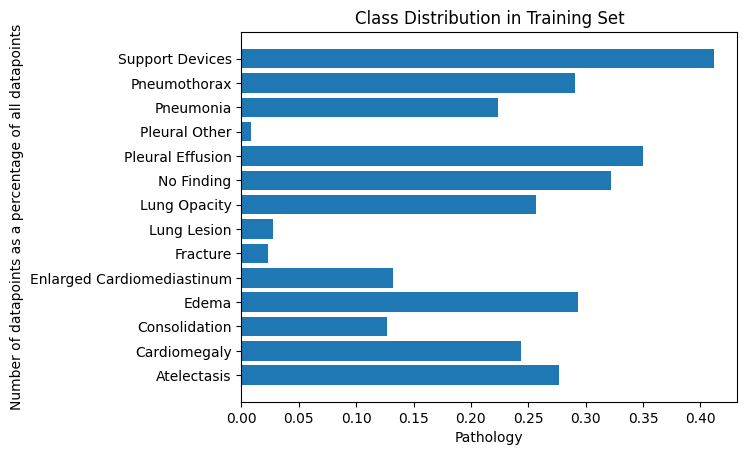

In [68]:
get_bar_chart("train")

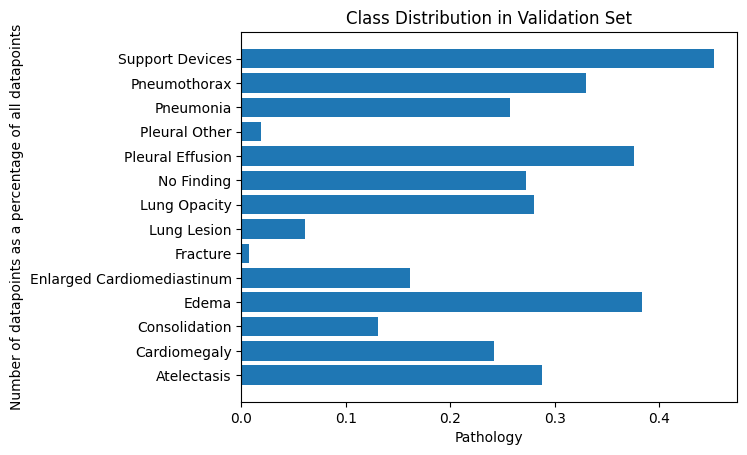

In [69]:
get_bar_chart("validate")

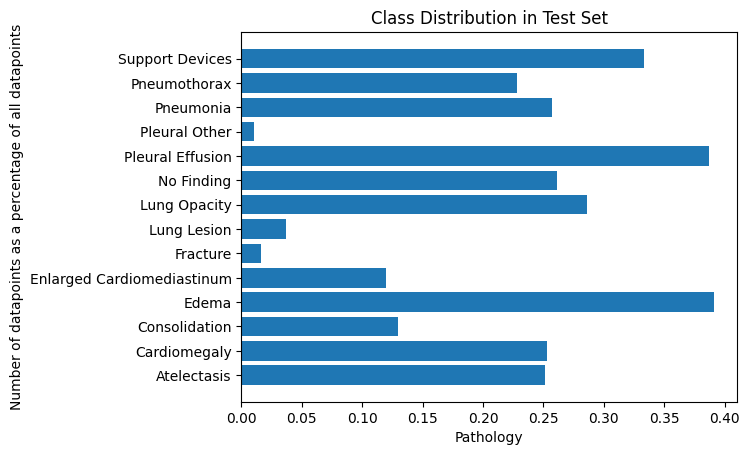

In [70]:
get_bar_chart("test")

## Part 5: Write the paths for the single AP images to a file

In [36]:
def write_image_filenames(df, patient_segment, output_file):
    f = open(f"./processed_data/{output_file}", "a")
    for row in df.itertuples():
        if patient_segment in row.image_path:
            f.write(row.image_path + "\n")
    f.close()

In [40]:
# write_image_filenames(
#     single_image_report_df[single_image_report_df["split"] == "train"],
#     "p",
#     "SINGLE_AP_IMAGE_FILENAMES_train",
# )

In [41]:
# write_image_filenames(
#     single_image_report_df[single_image_report_df["split"] == "validate"],
#     "p",
#     "SINGLE_AP_IMAGE_FILENAMES_validate",
# )

In [42]:
# write_image_filenames(
#     single_image_report_df[single_image_report_df["split"] == "test"],
#     "p",
#     "SINGLE_AP_IMAGE_FILENAMES_test",
# )

## Part 6: Create the json file that llava-med requires

In [43]:
import json
import jsonlines

In [44]:
def create_prompt(indication, include_indication):
    DEFAULT_IMAGE_TOKEN = "<image>"  # used by llava-med

    if include_indication:
        additional_prompt = f"The following is the indication for the patient: {indication}"
        base_prompt = "Analyze the Chest X-ray image and the patient's indication above and provide your findings."
        return f"{DEFAULT_IMAGE_TOKEN}\n{additional_prompt}\n{base_prompt}"
    else:
        base_prompt = "Question: Please write a radiology report that explains this chest X-ray image."
        return f"{DEFAULT_IMAGE_TOKEN}\n{base_prompt}"


def create_data_json(df, split, prompt_func, include_indication, output_file_path):
    '''
    Creates the json file used by LLava-Med for training
    '''
    data = []

    for row in df[df["split"] == split].itertuples():
        id = row.study_id
        report = row.report
        image = row.image_path

        prompt = prompt_func(row.indication, include_indication)

        data.append(
            {
                "id": id,
                "image": image,
                "conversations": [
                    {"from": "human", "value": prompt},
                    {"from": "gpt", "value": report},
                ],
            }
        )

    with open(f"{output_file_path}", "w") as f:
        json.dump(data, f)

def create_data_jsonl(df, split, prompt_func, include_indication, output_file_path):
    '''
    Creates the json file used by LLava-Med for training
    '''
    data = []

    for row in df[df["split"] == split].itertuples():
        id = row.study_id
        report = row.report
        image = row.image_path

        prompt = prompt_func(row.indication, include_indication)

        data.append(
            {
                "id": id,
                "image": image,
                "conversations": [
                    {"from": "human", "value": prompt},
                    {"from": "gpt", "value": report},
                ],
            }
        )

    with open(f"{output_file_path}", "w") as f:
        writer = jsonlines.Writer(f)
        writer.write_all(data)

In [73]:
# create_data_json(single_image_report_df, "train", create_prompt, True, "./processed_data/train_with_indication.json")
create_data_json(single_image_report_df, "train", create_prompt, True, "./processed_data/train_with_indication_removed_history.json")
create_data_json(single_image_report_df, "train", create_prompt, False, "./processed_data/train.json")
# create_data_jsonl(single_image_report_df, "train", create_prompt, True, "./processed_data/train_with_indication.jsonl")
# create_data_jsonl(single_image_report_df, "train", create_prompt, False, "./processed_data/train.jsonl")

In [41]:
create_data_json(single_image_report_df, "validate", create_prompt, True, "./processed_data/validate_with_indication_removed_history.json")
create_data_json(single_image_report_df, "validate", create_prompt, False, "./processed_data/validate.json")

In [42]:
create_data_json(single_image_report_df, "test", create_prompt, True, "./processed_data/test_with_indication_removed_history.json")
create_data_json(single_image_report_df, "test", create_prompt, False, "./processed_data/test.json")

## Part 7: Reduce the training data by sampling the training data randomly

In [45]:
import random
import numpy as np

In [ ]:
single_image_report_train_df = single_image_report_df[single_image_report_df["split"] == "train"]
rows = single_image_report_train_df.shape[0]
print("rows:", rows)

In [47]:
indices = np.arange(start=0, stop=rows, step=1).tolist()
keep_indices = random.sample(indices, k=28000) # 28k datapoints

In [48]:
sampled_single_image_report_train_df = single_image_report_train_df.iloc[keep_indices].sort_index().reset_index(drop=True)

In [ ]:
sampled_single_image_labels_df = sampled_single_image_report_train_df.merge(chexpert_df, on="study_id", suffixes=("", "_remove"))
sampled_single_image_labels_df.drop([i for i in sampled_single_image_labels_df.columns if "remove" in i], axis=1, inplace=True)
sampled_single_image_labels_df

In [ ]:
num_train_rows = 28000
sampled_single_image_train_class_distribution_df = pd.DataFrame(sampled_single_image_labels_df[sampled_single_image_labels_df["split"] == "train"].count()).T
sampled_single_image_train_class_distribution_df = sampled_single_image_train_class_distribution_df.apply(lambda x: x/num_train_rows)
sampled_single_image_train_class_distribution_df.drop(labels=["study_id", "size", "subject_id", "report_path", "dicom_id", "split", "image_path", "report", "indication"], axis=1)

In [51]:
# create_data_json(sampled_single_image_labels_df, "train", create_prompt, True, "./processed_data/train_with_indication_5k.json")
# create_data_json(sampled_single_image_labels_df, "train", create_prompt, True, "./processed_data/train_with_indication_removed_history_5k.json")
create_data_json(sampled_single_image_labels_df, "train", create_prompt, False, "./processed_data/train_28k.json")
# create_data_jsonl(sampled_single_image_labels_df, "train", create_prompt, True, "./processed_data/train_with_indication_5k.jsonl")
# create_data_jsonl(sampled_single_image_labels_df, "train", create_prompt, False, "./processed_data/train_5k.jsonl")